In [1]:
%pylab inline
from IPython.display import Math
import numpy as np
import pyhf

Populating the interactive namespace from numpy and matplotlib


Computing CLs
=============

In order to compute CLs you need to know the distribution of the value of the test statistic under a certain hypothesis. The test statistic is just a function of the observed data and the assumed model $f(\text{data},\text{model})$.

So the asymptotics paper [citation] basically gives some analytic formulae on what these distributions of test statistics look like. However, this makes some particular assumptions about the amount of statistics (events) in your model - so this only holds for a subset of cases.

In [2]:
def generate_spec(expected_signal, expected_background, observed):
    return {
    "channels": [
        {
            "name": "region",
            "samples": [
                {
                    "data": [
                        expected_signal
                    ],
                    "modifiers": [
                        {
                            "data": None,
                            "name": "mu_SIG",
                            "type": "normfactor"
                        }
                    ],
                    "name": "signal"
                },
                {
                    "data": [
                        expected_background
                    ],
                    "modifiers": [],
                    "name": "background"
                }
            ]
        }
    ],
    "observations": [{
        "name": "region", "data": [
            observed
        ]}
    ],
    "measurements": [
        {
            "config": {
                "poi": "mu_SIG",
                "parameters": []
            },
            "name": "meas"
        }
    ],
    "version": "1.0.0"
}

Asymptotics
===========

Analytic formula for distribution of test stat


Toys
====

Distribution of test stat approximated using a histogram from fake/sampled data

In [3]:
expected_signal = 10.0
expected_background = 100.0
observed = 25.0
# generate the spec given above events
spec = generate_spec(expected_signal, expected_background, observed)
workspace = pyhf.Workspace(spec)
print(f'Channels: {workspace.channels}')
print(f'Samples: {workspace.samples}')
print(f'Parameters: {workspace.parameters}')
print(f'Modifiers: {workspace.modifiers}')

Channels: ['region']
Samples: ['background', 'signal']
Parameters: ['mu_SIG']
Modifiers: [('mu_SIG', 'normfactor')]


In [4]:
pdf = workspace.model(measurement_name='meas')
data = workspace.data(pdf)
# what is the measurement?
workspace.get_measurement(measurement_name='meas')

{'config': {'poi': 'mu_SIG', 'parameters': []}, 'name': 'meas'}

In [5]:
mu_tests = np.linspace(0, 3, 31)
mu_tests

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. ])

In [6]:
hypo_tests = np.array([
    pyhf.infer.hypotest(
        mu,
        data,
        pdf,
        return_expected_set=True
    )
    for mu in mu_tests
])

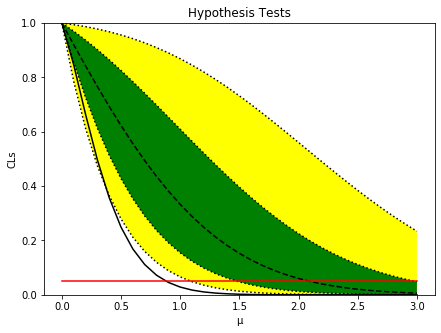

In [7]:
import pyhf.contrib.viz.brazil

fig, (ax1) = plt.subplots(1, 1)
fig.set_size_inches(7, 5)

ax1.set_title(u"Hypothesis Tests")
ax1.set_ylabel(u"CLs")
ax1.set_xlabel(u"µ")

pyhf.contrib.viz.brazil.plot_results(ax1, mu_tests, hypo_tests);

In [8]:
# given the hypo_tests, test_mus - interpolate to identify the intersections in the above plot
def invert_interval(test_mus, hypo_tests, test_size=0.05):
    cls_obs = np.array([test[0] for test in hypo_tests]).flatten()
    cls_exp = [
        np.array([test[1][i] for test in hypo_tests]).flatten() for i in range(5)
    ]
    crossing_test_stats = {"exp": [], "obs": None}
    for cls_exp_sigma in cls_exp:
        crossing_test_stats["exp"].append(
            np.interp(
                test_size, list(reversed(cls_exp_sigma)), list(reversed(test_mus))
            )
        )
    crossing_test_stats["obs"] = np.interp(
        test_size, list(reversed(cls_obs)), list(reversed(test_mus))
    )
    return crossing_test_stats

In [9]:
mu_expected_approx = 2*np.sqrt(expected_background)/expected_signal
mu_observed_approx = 2*np.sqrt(observed)/expected_signal

In [10]:
display(Math(rf'\mu_\text{{expected}} \approx {mu_expected_approx:.2f}'))
display(Math(rf'\mu_\text{{observed}} \approx {mu_observed_approx:.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [11]:
results = invert_interval(mu_tests, hypo_tests)
display(Math(rf'\mu_\text{{expected}} = {results["exp"][2]:.2f}'))
display(Math(rf'\mu_\text{{observed}} = {results["obs"]:.2f}'))

<IPython.core.display.Math object>

<IPython.core.display.Math object>